# Stationarity

Stationarity is a property of a time series when, roughly speaking, the mean and variance are constant in time. Let's plot a stationary time series:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [132]:
np.random.seed(50)

In [133]:
values = np.random.randn(50)
stationary_data = pd.Series(
    values,
    index=pd.date_range(start='2018-01-01', periods=len(values), freq='D')).to_frame()

stationary_data.columns = ['Values']

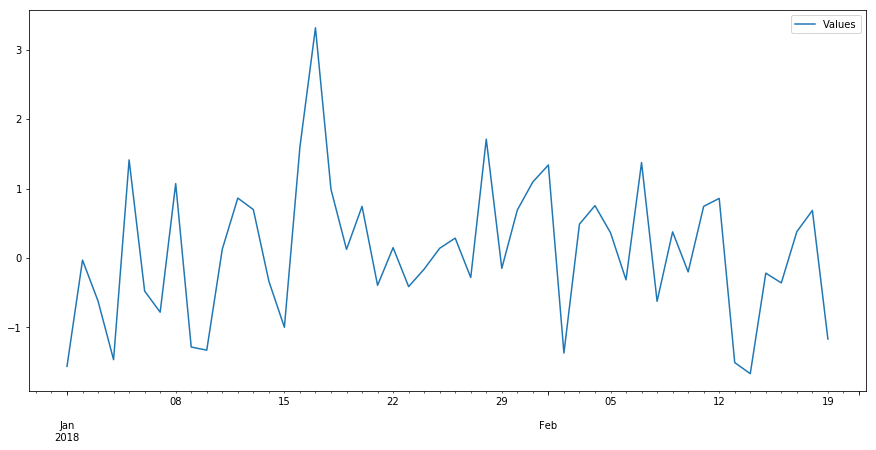

In [134]:
stationary_data.plot(figsize=(15, 7))

The time series "seems" stationary. We can check the variability of some of those parameters:

In [135]:
stationary_data['Rolling Mean'] = stationary_data['Values'].rolling(10).mean()
stationary_data['Rolling Std'] = stationary_data['Values'].rolling(10).std()

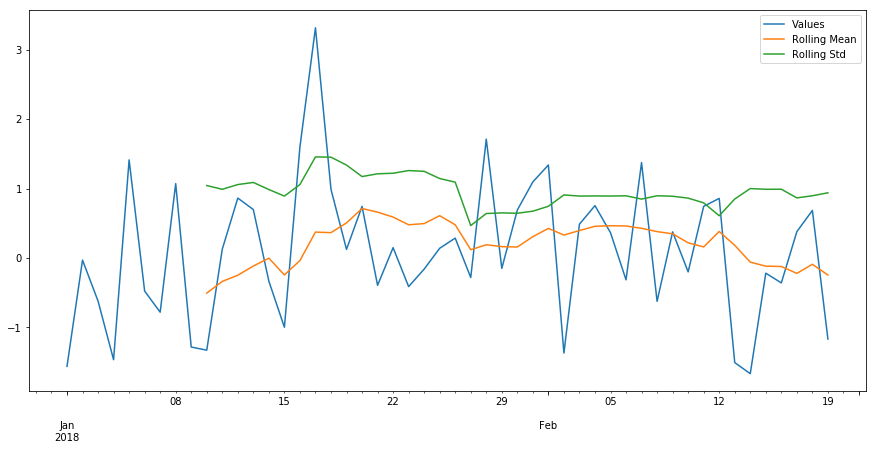

In [136]:
stationary_data.plot(figsize=(15, 7))

## A non-stationary process

A process can exhibit different key aspects that will let us quickly determine its non-stationary nature. The most common one is a trend:

In [137]:
non_stationary_data = pd.Series(
    np.random.randn(50) + np.arange(0, 15.0, .3),
    index=pd.date_range(start='2018-01-01', periods=len(values), freq='D')).to_frame()
non_stationary_data.columns = ['Values']

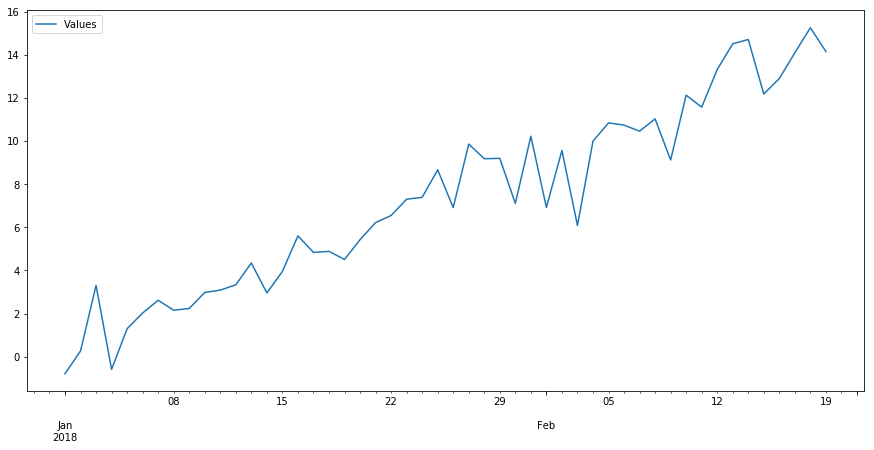

In [140]:
non_stationary_data.plot(figsize=(15, 7))

In [141]:
non_stationary_data['Rolling Mean'] = non_stationary_data['Values'].rolling(10).mean()
non_stationary_data['Rolling Std'] = non_stationary_data['Values'].rolling(10).std()

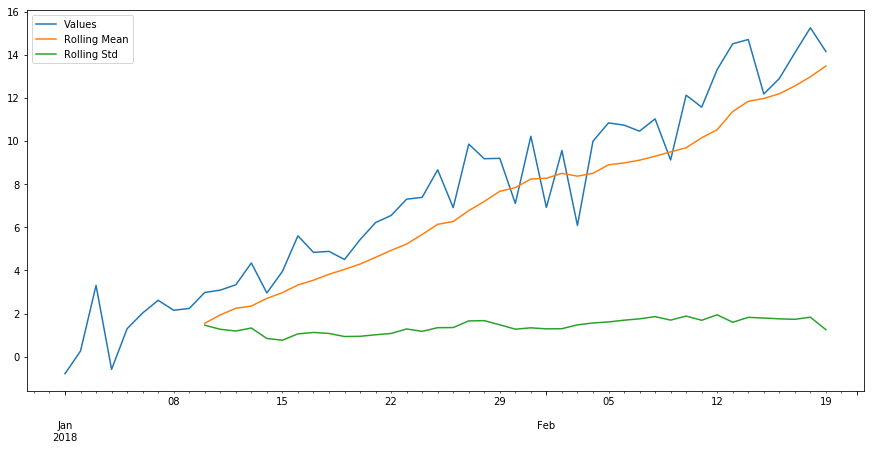

In [142]:
non_stationary_data.plot(figsize=(15, 7))

## Checking stationarity

There's a builtin test to check for stationarity. It's relatively simple to run and understand: the [Augmented Dickey–Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test).

It's already implemented in the [`statsmodels`](http://www.statsmodels.org/) package. We'll use the [`tsa`](http://www.statsmodels.org/stable/tsa.html) subpackage, that's intended for Time Series Analysis. The test is under [`tsa.adfuller`](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html):

In [177]:
from statsmodels.tsa.stattools import adfuller

Let's see what it returns:

In [178]:
adfuller(stationary_data['Values'])

(-6.3804906436768825,
 2.22860865534579e-08,
 0,
 49,
 {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153},
 108.65416418759642)

The `adfuller` function returns many parameters, as you can see in the docs. The most important one is the second value: the _p-value_.

The Augmented Dickey–Fuller test is a statistical tool, it returns a "confidence" value, an "approximation". A statistical tool will never tell you: "this is stationary". It'll tell you "there's a high change that's stationary, but I can NEVER be 100% sure.".

The null hypothesis of `adfuller` is that the process is NOT Stationary. If the p-value is large enough, the process is NOT stationary. If the p-value is **small enough**, we can reject the null hypothesis and assume the process is stationary. How small? We can set a confidence level, or a _cutoff value_ for our p-value. For example, 0.05:

In [250]:
def stationarity_check(time_series, cutoff=0.05):
    result = adfuller(time_series)
    p_value = result[1]
    stat_msg = 'non-stationary'

    if p_value <= cutoff:
        stat_msg = 'stationary'
        
    print("P-value = {:.13f}. Data is likely {}".format(p_value, stat_msg))

So, for our stationary dataset we'll obtain:

In [189]:
stationarity_check(stationary_data['Values'])

P-value = 0.0000000222861. Data is likely stationary


And for our non-stationary data:

In [190]:
stationarity_check(non_stationary_data['Values'])

P-value = 0.9098725542722. Data is likely non-stationary


## A more realistic example

We'll use our toothbrush bookings data to check for stationarity:

In [207]:
tb = pd.read_csv(
    'data/tb-sales.csv',
    index_col=0,
    parse_dates=True
)

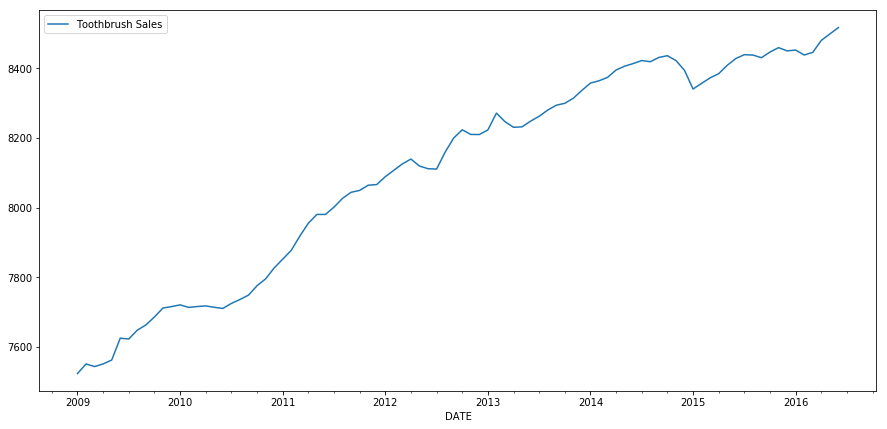

In [213]:
tb.plot(figsize=(15, 7))

It's pretty obvious from the plot that is highly likely that this process is non-stationary. Let's use our `adfuller` test:

In [214]:
stationarity_check(tb['Toothbrush Sales'])

P-value = 0.5205354140784. Data is likely non-stationary


## Making a process stationary

The simplest way to make a process stationary is by "differencing" it. That is, subtracting it with itself 🤔. It's simple, let's do it step by step:

In [218]:
tb.drop(columns='First Difference', inplace=True)

In [219]:
tb['Shift 1'] = tb['Toothbrush Sales'].shift(1)

In [220]:
tb.head()

,Toothbrush Sales,Shift 1
DATE,,
2009-01-01,7523.6215,NaN
2009-02-01,7551.0275,7523.6215
2009-03-01,7543.5725,7551.0275
2009-04-01,7551.1695,7543.5725
2009-05-01,7562.2810,7551.1695


In [224]:
tb['First Difference'] = tb['Toothbrush Sales'] - tb['Shift 1']

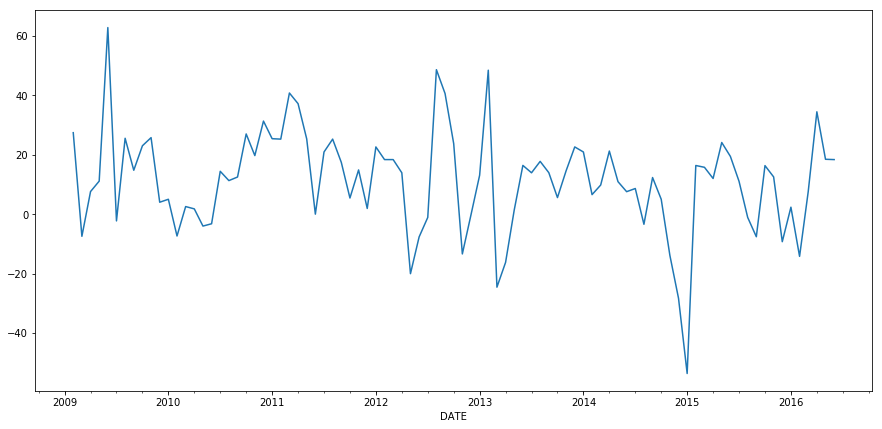

In [225]:
tb['First Difference'].plot(figsize=(15, 7))

It looks a lot more stationary now! We can run our `adfuller` test:

In [227]:
stationarity_check(tb['First Difference'][1:])

P-value = 0.0000000020295. Data is likely stationary


There's actually a builtin pandas method to take the difference:

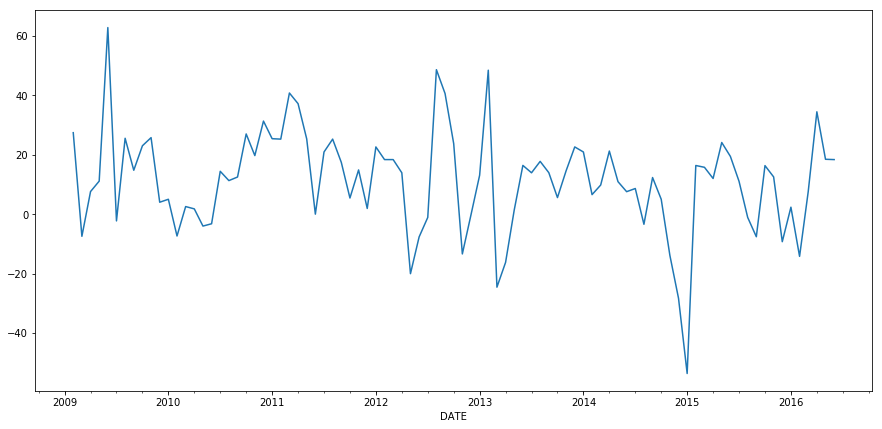

In [229]:
tb['Toothbrush Sales'].diff().plot(figsize=(15, 7))

In [231]:
stationarity_check(tb['Toothbrush Sales'].diff()[1:])

P-value = 0.0000000020295. Data is likely stationary


## Working with Seasonal data

We'll now use another example. In his case, we'll use our hotel bookings data to check for stationarity.

In [240]:
bookings = pd.read_csv('data/bookings-processed.csv', index_col=0, parse_dates=True)

In [241]:
bookings.head()

,Bookings
Period,
2006-01-01,383
2006-02-01,366
2006-03-01,250
2006-04-01,318
2006-05-01,334


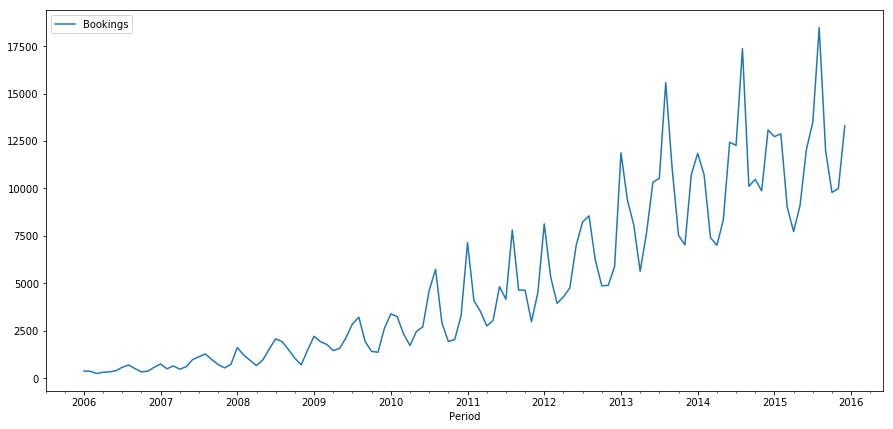

In [242]:
bookings.plot(figsize=(15, 7))

It's pretty obvious from the plot that the process is non-stationary AND seasonal. It has a pretty high seasonal component: there's a spike every 12 months.

In [243]:
stationarity_check(bookings['Bookings'])

P-value = 0.9940915643246. Data is likely non-stationary


We'll try differencing it and seeing what happens:

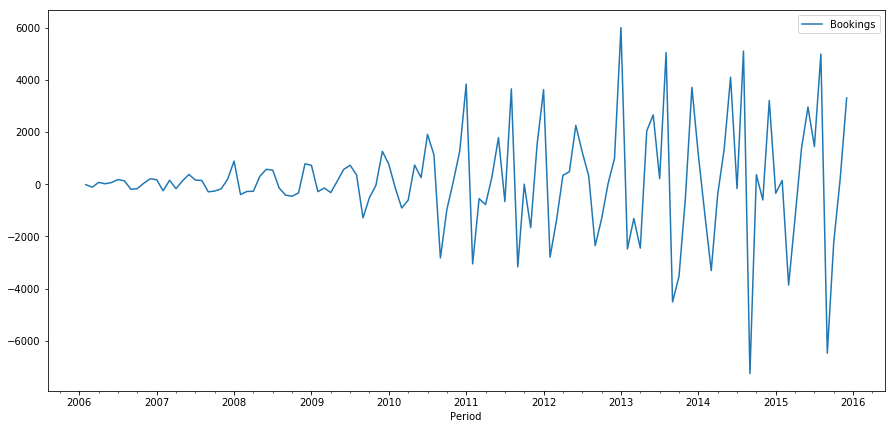

In [245]:
bookings.diff().dropna().plot(figsize=(15, 7))

This process looks less stationary, what does our check says?

In [246]:
stationarity_check(bookings.diff().dropna()['Bookings'])

P-value = 0.0043503153532. Data is likely stationary


In this case, our check says it's stationary, so we've made it stationary. But remember that WE chose the p-value to decide if we'd consider the process stationary. What happens if we define a much lower p-value?

In [254]:
stationarity_check(bookings.diff().dropna()['Bookings'], 0.003)

P-value = 0.0043503153532. Data is likely non-stationary


In [255]:
bookings.head()

,Bookings
Period,
2006-01-01,383
2006-02-01,366
2006-03-01,250
2006-04-01,318
2006-05-01,334


The problem with our dataset is that seasonality matters. Usually, when using seasonal datasets, we prefer to differentiate it by seasons. That is, subtract July 2016 from July 2017, instead of July 2016 from August 2016. To do that, we can use the `periods` parameter of the `diff` method:

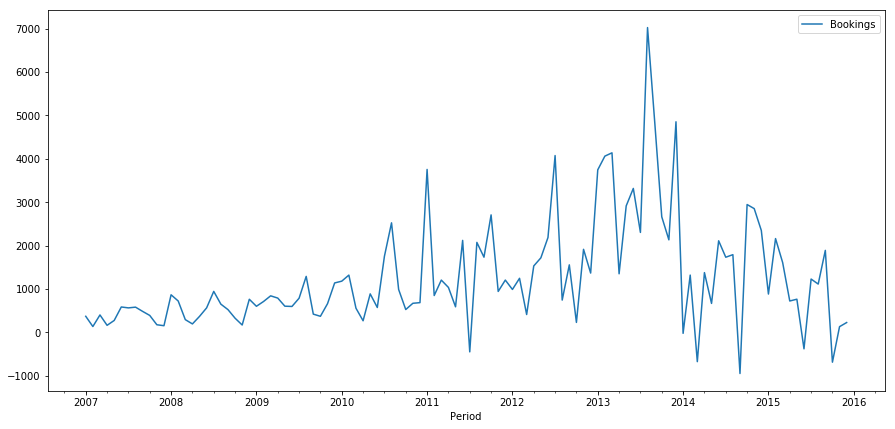

In [256]:
bookings.diff(12).dropna().plot(figsize=(15, 7))

And our `adfuller` test says:

In [259]:
stationarity_check(bookings.diff(12)['Bookings'].dropna(), 0.002)

P-value = 0.0011672437237. Data is likely stationary


Just as a reminder, we're basically doing:

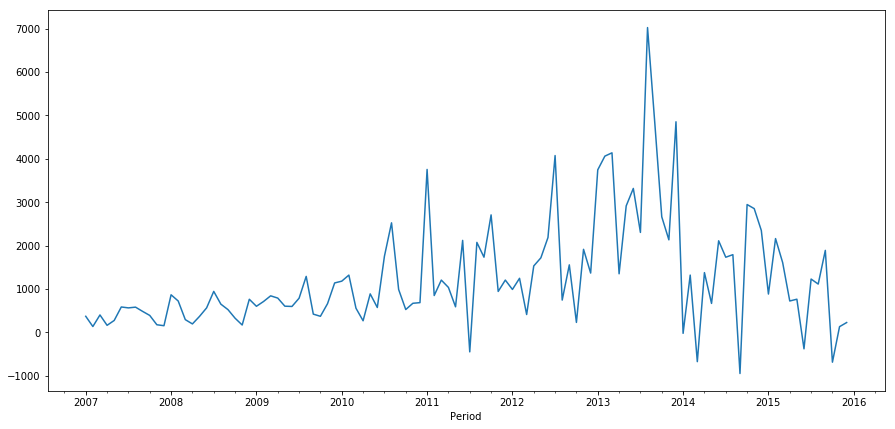

In [257]:
(bookings['Bookings'] - bookings['Bookings'].shift(12)).plot(figsize=(15, 7))